In [88]:
# import libraries
import numpy as np
import pickle
import os
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
%matplotlib inline
import random
import librosa
from scipy.stats import kurtosis, skew
from sklearn import svm
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,roc_auc_score,ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')


In [91]:
# get file list for 1 patient
def get_file_list(path):
    file_list = []
    label = []
    for i in os.listdir(path):
        file_list.append(i)
        if i.endswith("001.csv"):
            label.append(0)
        elif i.endswith("002.csv"):
            label.append(1)
        elif i.endswith("003.csv"):
            label.append(2)
        elif i.endswith("004.csv"):
            label.append(3)
        elif i.endswith("005.csv"):
            label.append(4)
        elif i.endswith("006.csv"):
            label.append(5)
        elif i.endswith("007.csv"):
            label.append(6)
        elif i.endswith("008.csv"):
            label.append(7)
        elif i.endswith("009.csv"):
            label.append(8)
        elif i.endswith("010.csv"):
            label.append(9)
        elif i.endswith("011.csv"):
            label.append(10)
        elif i.endswith("012.csv"):
            label.append(11)

    
    return label,file_list

In [92]:
# get feature from 1 file and normalize
def get_feature(path):
    f = []
    scaler = MinMaxScaler()
    a = pd.read_csv(path,names=["vertical","horizontal"])
    a = np.array(a)
    a = scaler.fit_transform(a)
    for j in a[:,0]:
        f.append(j)        
    for j in a[:,1]:
        f.append(j)
    return f
    
    

In [93]:
# self identified test_split
def my_train_test_split_user_dependent(path,test_split,file_list,label):
    X_test = []
    X_train = []
    y_train = []
    y_test = []
    for f in range(len(file_list)):
        file = file_list[f]
        file_label = label[f]
        feature = get_feature(str(path+file))
        #print(file.split('_')[2],file_label)
        if file.split('_')[2] in test_split:
            X_test.append(feature)
            y_test.append(file_label)
            #print(file,len(feature))
        else:
            X_train.append(feature)
            y_train.append(file_label)
            #print(file)

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    return X_train,X_test, y_train,y_test

In [94]:
def evaluate(y_true, y_pred,y_prob):
    f1 = f1_score(y_true, y_pred,average = 'micro')
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1,2,3,4,5,6,7,8,9,10,11])
    disp.plot()
    plt.show()
    class_accuracy = cm.diagonal()/cm.sum(axis=1)
    specificity = class_accuracy[1]
    sensitivity = class_accuracy[0]
    auc = roc_auc_score(y_true,y_prob,multi_class="ovr",average="micro")

    return f1,acc,specificity,sensitivity,auc,cm

## User dependent

In [95]:
patient = ["001","002","003","004","005","006"]
test_split = [["01","02"],["03","04"],["05","06"],["07","08"],["09","10"]]

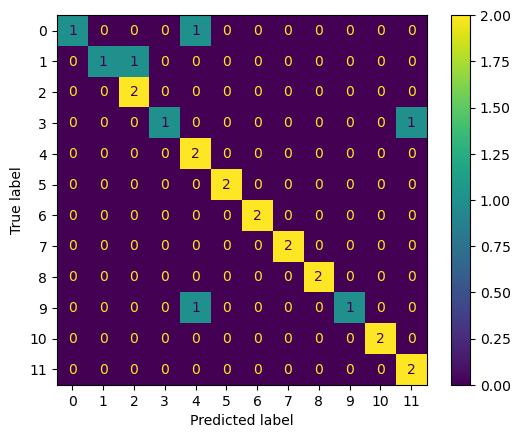

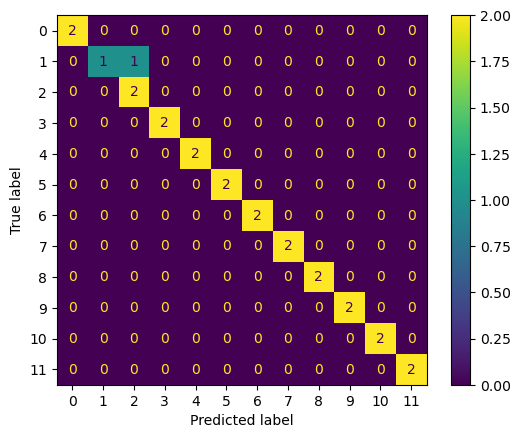

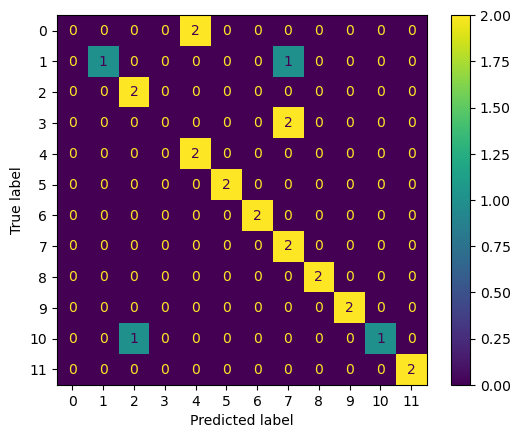

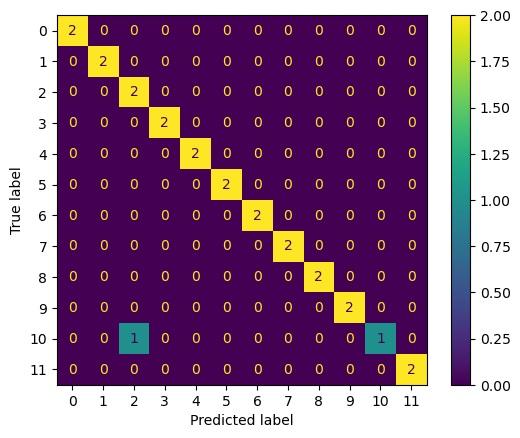

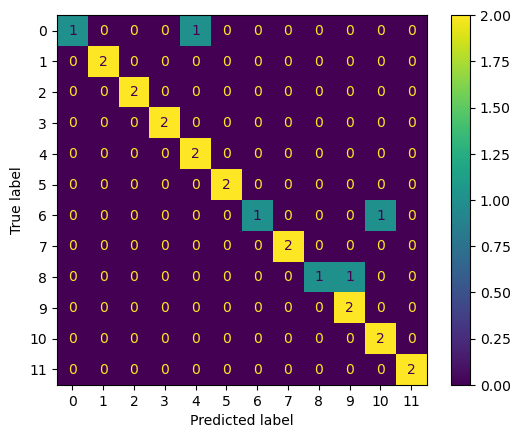

001 0.875 0.875 0.7 0.6 0.992550505050505


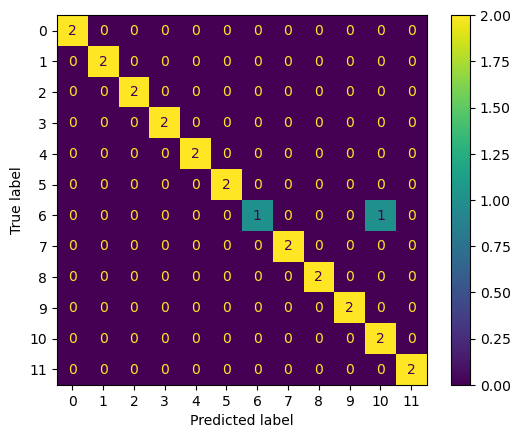

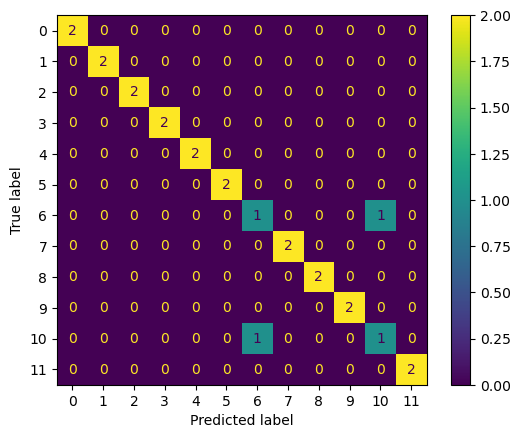

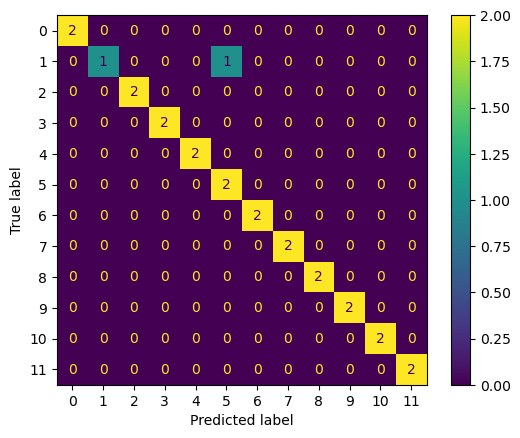

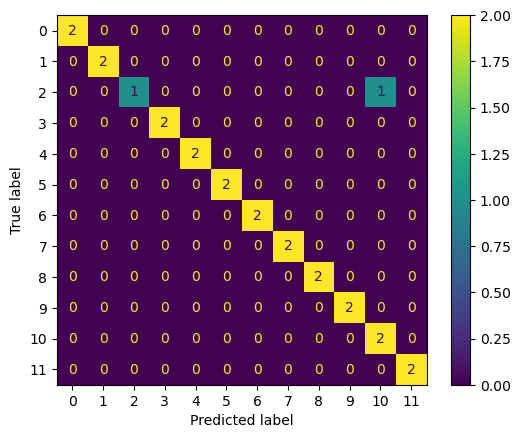

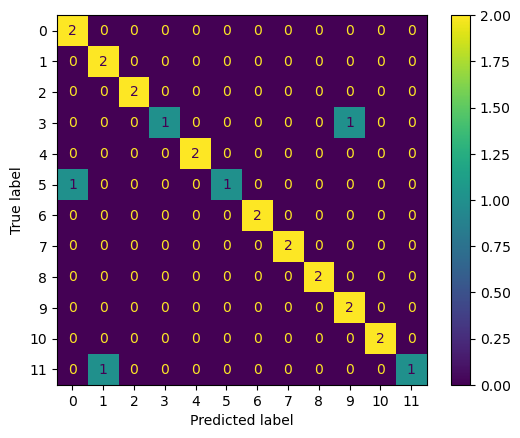

002 0.9333333333333333 0.9333333333333333 0.9 1.0 0.9978535353535353


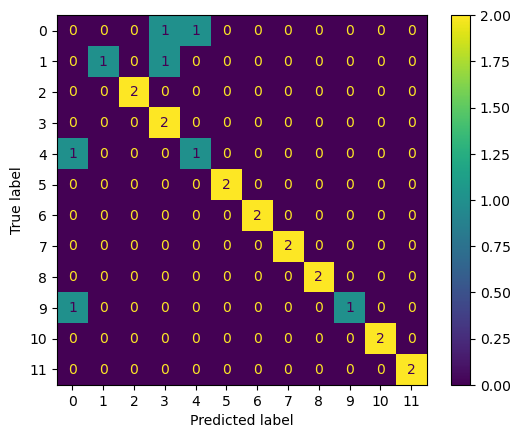

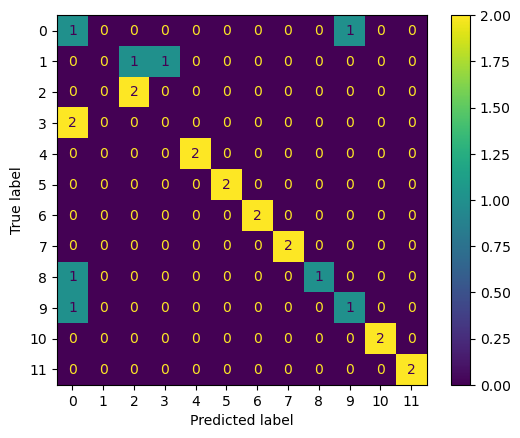

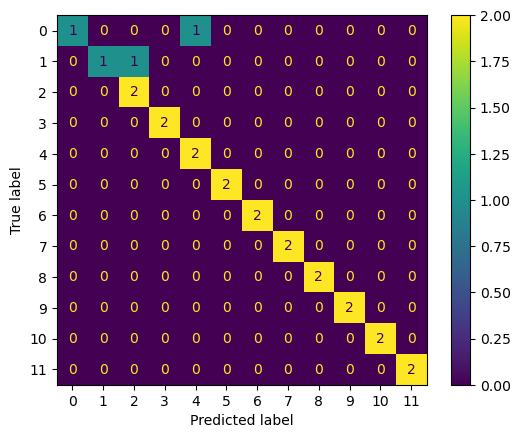

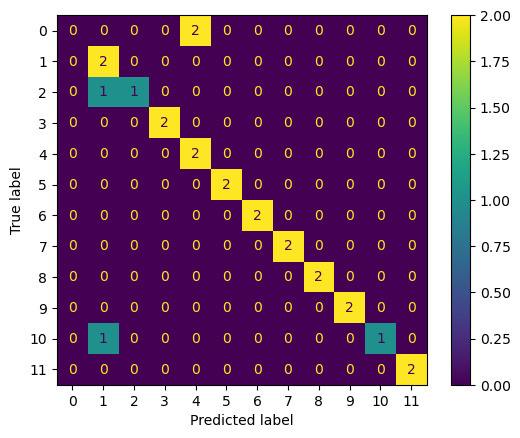

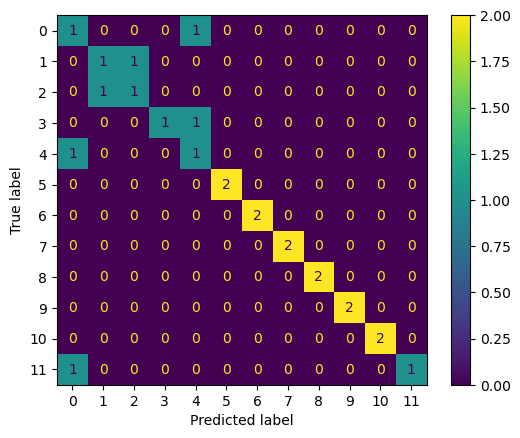

003 0.8 0.8 0.5 0.3 0.9818497474747476


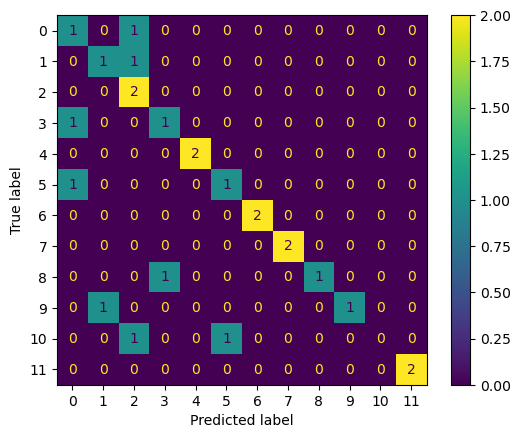

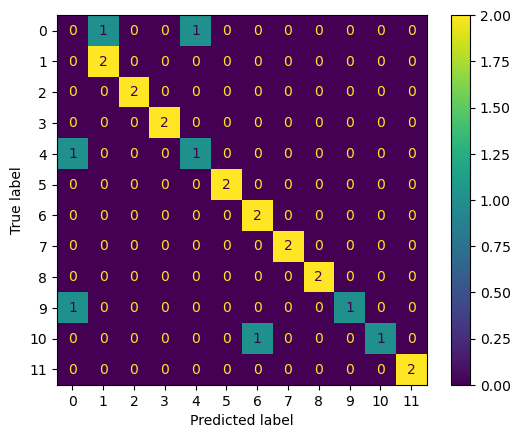

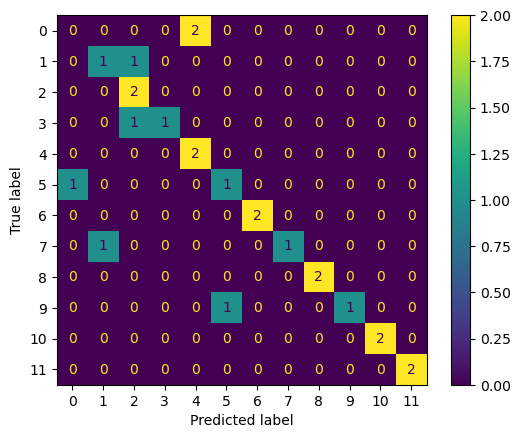

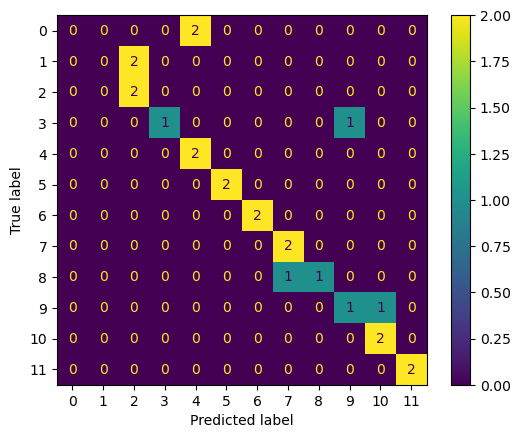

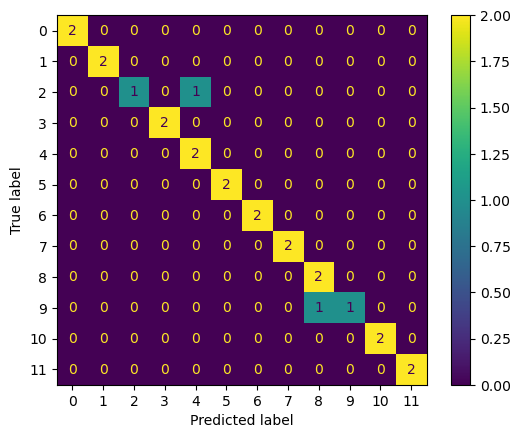

004 0.7583333333333333 0.7583333333333333 0.6 0.3 0.9611426767676768


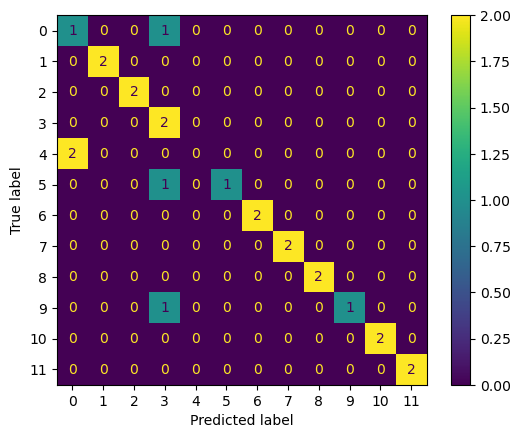

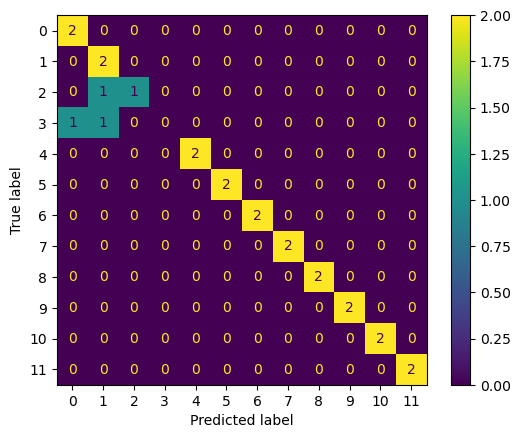

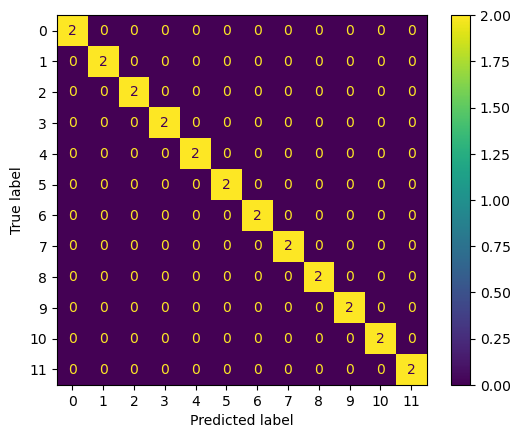

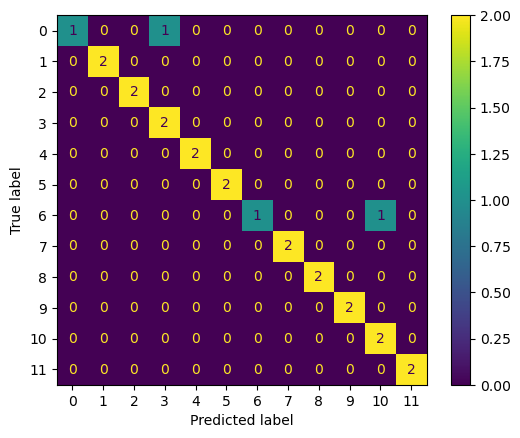

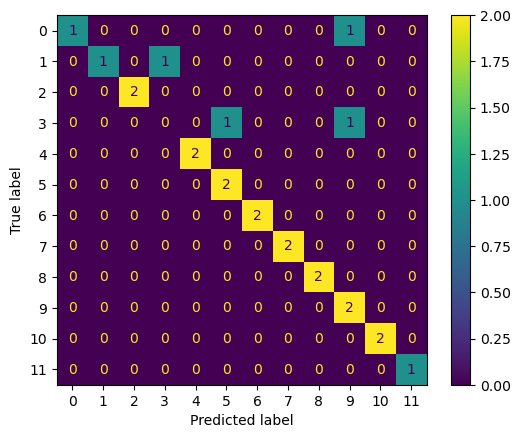

005 0.8818840579710144 0.8818840579710144 0.9 0.7 0.9934056419583357


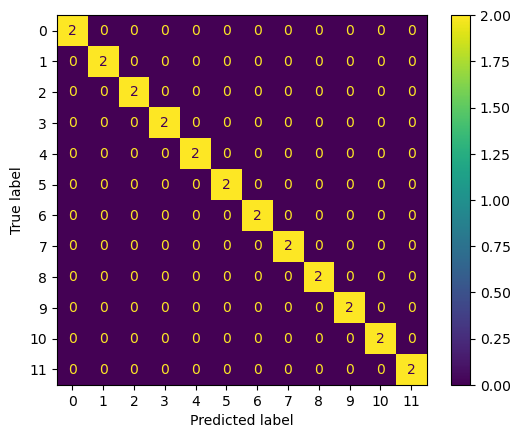

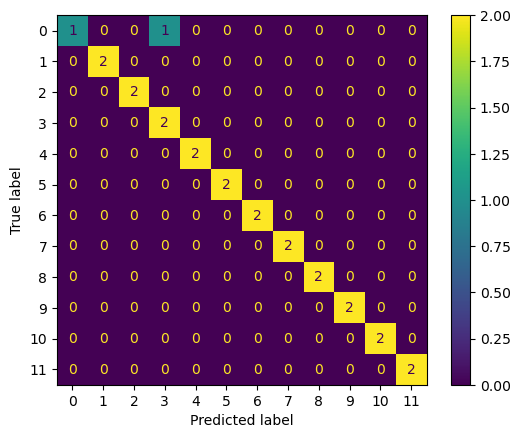

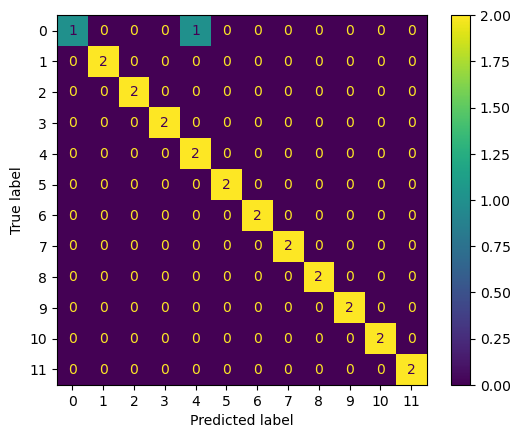

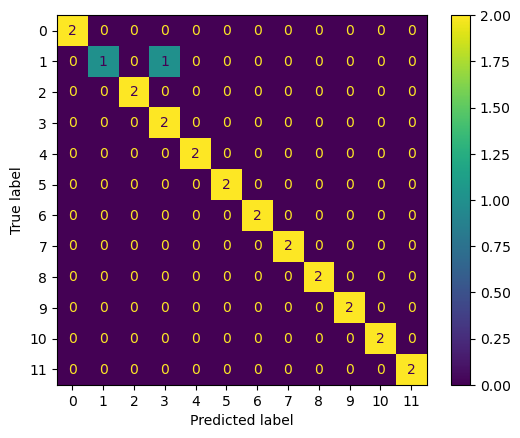

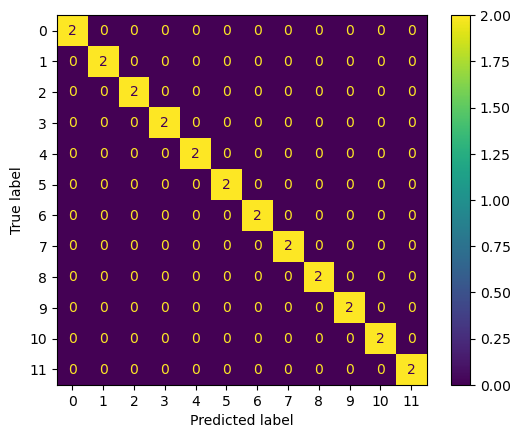

006 0.975 0.975 0.9 0.8 0.9991161616161616
total accuracy 0.8705917874396135 total f1 0.8705917874396135 total auc 0.9876530447034937 total spec 0.75 total sens 0.6166666666666667


In [96]:
Total_acc = 0
total_f1 = 0
total_auc = 0
total_spec = 0
total_sens = 0
for p in patient:
    #print(p)
    output_pck = []
    path = path = str("../../data/isolated 2/"+p+"/isolated_strokes/")
    Acc = 0
    F1 = 0
    AUC = 0
    Spec = 0
    Sens = 0
    for t in test_split:
        label,file_list = get_file_list(path)
        X_train,X_test, y_train,y_test = my_train_test_split_user_dependent(path,t,file_list,label)
        #print(X_train.shape,X_test.shape)
         # build model
        clf = svm.SVC(probability=True,random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)
        f1,acc,specificity,sensitivity,auc,cm = evaluate(y_test, y_pred,y_prob)
        Acc += acc
        F1 += f1
        AUC += auc
        Spec += specificity
        Sens += sensitivity
        #print(accuracy)
        output = dict()
        output["test_split"] = t
        output["X_train"] = X_train
        output["X_test"] = X_test
        output["y_test"] = y_test
        output["y_train"] = y_train
        output["clf"] = clf
        output["accuracy"] = acc
        output["f1"] = f1
        output["specificity"] = specificity
        output["sensitivity"] = sensitivity
        output["auc"] = auc
        output["confusion_matrix"] = cm
        output_pck.append(output)
    with open(str("./User_dependent/patient_"+p+"_SVC.pck"), "wb") as output_file:
        pickle.dump(output_pck, output_file)
    print(p,Acc/5,F1/5,Spec/5,Sens/5,AUC/5)
    Total_acc += Acc/5
    total_f1 += F1/5
    total_auc += AUC/5
    total_spec += Spec/5
    total_sens += Sens/5

print("total accuracy",Total_acc/6,"total f1",total_f1/6,"total auc",total_auc/6,"total spec",total_spec/6,
      "total sens",total_sens/6)
        
    
    

## User independent

In [98]:
# self identified test_split
def my_train_test_split_user_independent(test_patient,train_patient):
    X_test = []
    X_train = []
    y_train = []
    y_test = []
    for p in train_patient:
        path = str("../../data/isolated 2/"+p+"/isolated_strokes/")
        label,file_list = get_file_list(path)
        for i in range(len(file_list)):
            file = file_list[i]
            file_label = label[i]
            feature = get_feature(str(path+file))
            X_train.append(feature)
            y_train.append(file_label)
        
    path = str("../../data/isolated 2/"+test_patient+"/isolated_strokes/")
    label,file_list = get_file_list(path)
    for i in range(len(file_list)):
        file = file_list[i]
        file_label = label[i]
        feature = get_feature(str(path+file))
        X_test.append(feature)
        y_test.append(file_label)

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    return X_train,X_test, y_train,y_test

(604, 2500) (120, 2500) (604,) (120,)


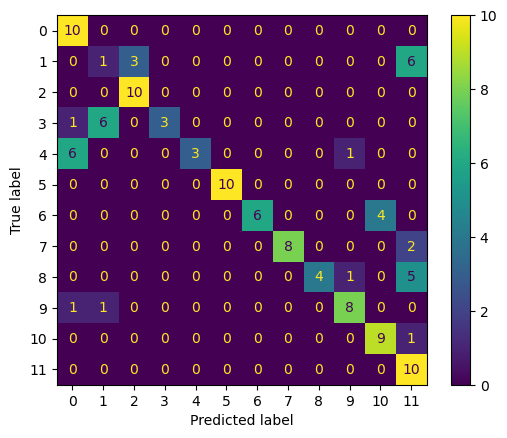

(604, 2500) (120, 2500) (604,) (120,)


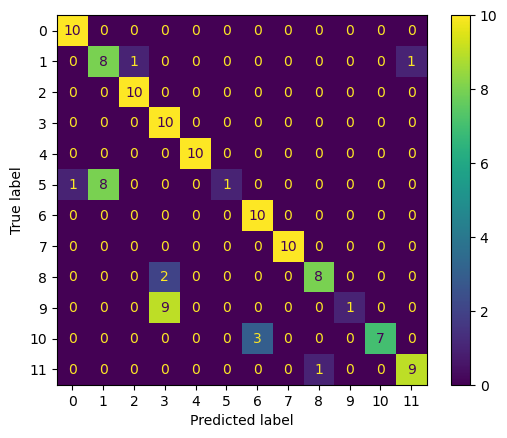

(602, 2500) (122, 2500) (602,) (122,)


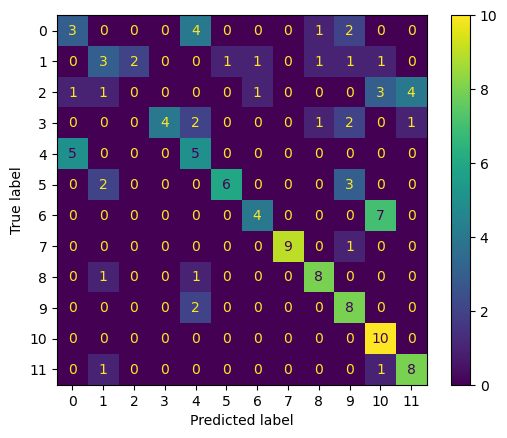

(603, 2500) (121, 2500) (603,) (121,)


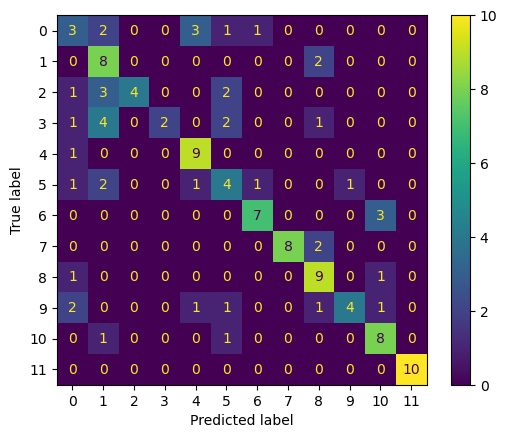

(604, 2500) (120, 2500) (604,) (120,)


In [ ]:
patient = ["001","002","003","004","005","006"]
output_pck = []
F1 = 0
Acc = 0
Spec = 0
Sens = 0
Auc = 0 
for test_patient in patient:
    train_patient= ["001","002","003","004","005","006"]
    train_patient.remove(test_patient)
    X_train,X_test, y_train,y_test = my_train_test_split_user_independent(test_patient,train_patient)
    print(X_train.shape,X_test.shape, y_train.shape,y_test.shape)
    clf = svm.SVC(probability=True,random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)
    f1,acc,specificity,sensitivity,auc,cm = evaluate(y_test, y_pred,y_prob)
    output = dict()
    output["test_split"] = test_patient
    output["X_train"] = X_train
    output["X_test"] = X_test
    output["y_test"] = y_test
    output["y_train"] = y_train
    output["clf"] = clf
    output["accuracy"] = acc
    output["f1"] = f1
    output["specificity"] = specificity
    output["sensitivity"] = sensitivity
    output["auc"] = auc
    output["confusion_matrix"] = cm
    output_pck.append(output)
    F1 += f1
    Acc += acc
    Spec += specificity
    Sens += sensitivity
    Auc += auc

print("F1:",F1/6," Accuracy: ",Acc/6," specificity: ",Spec/6," sensitivity: ",Sens/6," Auc: ",Auc/6)    
    

In [70]:
print('\nSaving the object')
with open("User_independent/User-independent-SVC.pck", "wb") as output_file:
    pickle.dump(output, output_file)


Saving the object
